# Preparations

Let's import some modules and review dataset

In [86]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [88]:
df = pd.read_csv("../input/train_task1_latest.csv")
df.head()

,paragraph_id,question_id,paragraph,question,target
0,1094,46273,"В отличие от рыб, земноводные (амфибии) и прес...",С какого года Русское Царство перешло на летои...,0.0
1,7414,19164,В 1049 году Балдуину V удалось отнять у Герман...,Кто упомянул о его первых разногласиях со Штей...,0.0
2,6744,39767,Стремление достичь предельных значений ёмкости...,Как называется имеющая мировое значение эпоха ...,0.0
3,7300,36318,Первый практически пригодный двухтактный газов...,Что усугублялось из-за международного давления...,0.0
4,7077,41534,Требуя от художника углубленного изучения изоб...,Какой характер носят пророчества Леонардо да В...,0.0


In [89]:
df_test = pd.read_csv("../input/sdsj_A_test.csv")
df_test.head()

,paragraph_id,question_id,paragraph,question
0,1361,6463,"Передний мозг сильно развит, это самая большая...",В какой мифологии два ворона Хугин и Мунин шеп...
1,1403,34696,Мирмекологи исследуют муравьёв как в лаборатор...,Когда инсайдер покупает или гипотезы чего эвол...
2,1435,13751,Волновая: свет представляет собой волну в неви...,"Какие предположения, по мнению Ньютона, допуст..."
3,341,38544,Живые организмы подчиняются началам термодинам...,В каких условиях метаболизм поддерживает поряд...
4,1317,14589,Файлы нелатинского текста в Юникоде всегда зан...,Каким мелодиям Прокофьева особенно не укладыва...


In [90]:
df.describe(include="all")

,paragraph_id,question_id,paragraph,question,target
count,119398.000000,119398.000000,119398,119398,119398.000000
unique,NaN,NaN,9078,38868,NaN
top,NaN,NaN,Отец Ивана Сергей Николаевич Тургенев (1793—18...,К кому обратился Иван Алексеевич с просьбой о ...,NaN
freq,NaN,NaN,3294,51,NaN
mean,4592.034959,50461.854411,NaN,NaN,0.285072
std,2567.712213,29081.761678,NaN,NaN,0.451451
min,0.000000,0.000000,NaN,NaN,0.000000
25%,2398.000000,25319.000000,NaN,NaN,0.000000
50%,4714.000000,50516.000000,NaN,NaN,0.000000
75%,6643.000000,75564.750000,NaN,NaN,1.000000


So we have 119398 paragraph-question pairs with 9078 unique paragraphs and 38868 unique questions.
Let's see tasget class balance:

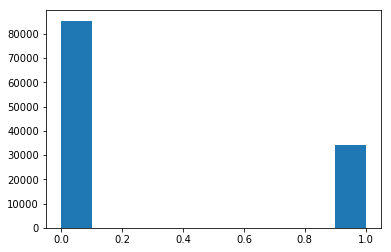

In [92]:
plt.hist(df["target"]);

# Utils

We'll use some utils functions:

In [93]:
from ipywidgets import IntProgress
from IPython.display import display


def log_progress(sequence, every=10):
    progress = IntProgress(min=0, max=len(sequence), value=0)
    display(progress)
    for index, record in enumerate(sequence):
        if index % every == 0:
            progress.value = index
        yield record

# Baseline

We'll use next idea:
- convert text to reduce unique tokens count (with stemming)
- train word2vec
- calculate "distance" between question and paragraph next way:
    - calculate cosine distances between each question/paragraph word vectors
    $$ distance(questionWord_i, paragraphWord_j) = cosine(vector(questionWord_i), vector(paragraphWord_j)) $$
    - for each question word - get minimal distance value
    $$ distance(questionWord_i, paragraph) = min(distance(questionWord_i, paragraph_j) for j=0..N) $$
    - return mean and std values of chosen distances

## Text preprocesing
Let's write text preprocessing function:

In [124]:
from functools import lru_cache
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import RussianStemmer
import re


def _no_token_filter(token):
    return True


@lru_cache(60000)
def _stem_text(text, stemmer, token_filter):
    tokens = word_tokenize(text.lower())
    words = filter(lambda token: re.match("\w+", token) and token_filter(token), tokens)
    stems = map(stemmer.stem, words)
    return list(stems)


def stem_texts(texts, stemmer, token_filter=None):
    if token_filter == None:
        token_filter = _no_token_filter
    return list(map(lambda text: _stem_text(text, stemmer, token_filter),
                    log_progress(texts)))

and apply it

In [125]:
paragraph_train = stem_texts(df["paragraph"], RussianStemmer())

IntProgress(value=0, max=119398)

In [126]:
paragraph_test = stem_texts(df_test["paragraph"], RussianStemmer())

IntProgress(value=0, max=74286)

In [127]:
question_train = stem_texts(df["question"], RussianStemmer())

IntProgress(value=0, max=119398)

In [128]:
question_test = stem_texts(df_test["question"], RussianStemmer())

IntProgress(value=0, max=74286)

## Word2Vec

In [107]:
from gensim.models import Word2Vec

w2v = Word2Vec(paragraph_train + question_train)

In [131]:
w2v.wv.save_word2vec_format("../data/word2vec.bin", binary=True)

## Paragraph/question distance

Now let's implement function to compute question-paragraph distances:

In [110]:
from sklearn.metrics.pairwise import cosine_distances
import numpy as np

def _pair_distance(question, paragraph, word2vec):
    def _text_vectors(text):
        return np.array([word2vec[word]
                         for word in text
                         if word in word2vec])
    
    question_vectors = _text_vectors(question)
    paragraph_vectors = _text_vectors(paragraph)
    distances = cosine_distances(question_vectors, paragraph_vectors)
    word_min_distances = np.zeros([len(question_vectors)])
    for i in range(0, len(question_vectors)):
        word_min_distances[i] = distances[i, :].min()
    return word_min_distances.mean(), word_min_distances.std()

And check it at some unrelevant...

In [111]:
_pair_distance(question_train[0], paragraph_train[0], w2v)

(0.58261939457484657, 0.30947489579757553)

In [51]:
_pair_distance(question_train[1], paragraph_train[1], w2v)

(0.55719318120710315, 0.24613565908103013)

and relevant questions:

In [52]:
_pair_distance(question_train[7], paragraph_train[7], w2v)

(0.14855333831575182, 0.27825677099734109)

In [112]:
_pair_distance(question_train[8], paragraph_train[8], w2v)

(0.02130671011077033, 0.087849657302396647)

Seems like relevant questions can have lesser distance with (relative) good standart deviation.
So let's define function to calculate distances between multiple question-paragraph pairs:

In [113]:
def pairs_distances(questions, paragraphs, word2vec):
    assert len(questions) == len(paragraphs)
    result = np.zeros([len(questions), 2])
    indices = list(range(0, len(paragraphs)))
    for i in log_progress(indices, every=3):
        result[i, :] = _pair_distance(questions[i], paragraphs[i], word2vec)
    return result

And run it on our dataset

In [114]:
%%time
distances_train = build_distances(question_train, paragraph_train)

IntProgress(value=0, max=119398)

Wall time: 4min 5s


In [115]:
%%time
distances_test = build_distances(question_test, paragraph_test)

IntProgress(value=0, max=74286)

Wall time: 2min 43s


In [132]:
np.save("../data/distances_train.npy", distances_train)
np.save("../data/distances_test.npy", distances_test)

## Classifier training

Let's check how LogisticRegression will work with our distances and std-deviations:

In [116]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.linear_model import LogisticRegression


cross_val_score(LogisticRegression(),
                distances_train,
                df["target"],
                scoring=make_scorer(roc_auc_score))

array([ 0.9220896 ,  0.92132673,  0.92385814])

At least - it's better that 0.5 :-)

Let's train LogisticRegression on all train dataset and make predictions for test set:

In [117]:
regression = LogisticRegression()
regression.fit(distances_train, df["target"])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [120]:
target_class_index = regression.classes_.tolist().index(1)
prediction = regression.predict_proba(distances_test)[:, target_class_index]

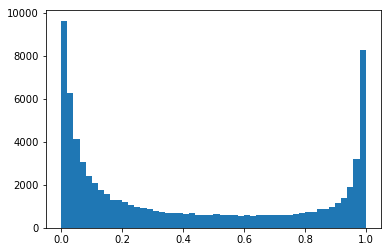

In [130]:
plt.hist(prediction, bins=50);

In [122]:
from collections import OrderedDict

prediction_proba_df = pd.DataFrame(OrderedDict([
    ("paragraph_id", df_test["paragraph_id"]),
    ("question_id", df_test["question_id"]),
    ("prediction", prediction_proba[:, 1])
]))
prediction_proba_df.to_csv("../output/wmd.csv", index=False)